In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import config

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb

import pickle
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_parquet('../data/processed/scores_approvals_convocation_2020_2022.parquet')
df2 = pd.read_parquet('../data/processed/scores_approvals_convocation_2019_2021.parquet')

In [4]:
FEATURES = ['escore_bruto_p1_etapa1',
            'escore_bruto_p2_etapa1',
            #'nota_redacao_etapa1',
            'escore_bruto_p1_etapa2',
            'escore_bruto_p2_etapa2',
            #'nota_redacao_etapa2',
            'escore_bruto_p1_etapa3',
            'escore_bruto_p2_etapa3',
            #'nota_redacao_etapa3',
            'pseudo_argumento_final',
            'min_flag',
            'median_flag',
            #'dist_max',
            #'dist_mean',
            #'cotista',
            'cotas_negros_flag',
            #'publicas_flag',
            'publicas1_flag',
            'publicas2_flag',
            'publicas3_flag',
            'publicas4_flag',
            'publicas5_flag',
            'publicas6_flag',
            'publicas7_flag',
            'publicas8_flag',
            'course'
            ]
len(FEATURES)

19

In [5]:
cat_type = CategoricalDtype(categories=config.COURSE_NAMES)

In [6]:
df['course'] = df['course'].astype(cat_type)
shuffled_df = df.sample(frac=1, random_state=42)
X = shuffled_df[FEATURES] # features
y = shuffled_df['label'] # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47) # 70% training and 30% test

In [7]:
print(X_train.shape)
print(y_train.shape)

(5810, 19)
(5810,)


In [8]:
y_train.value_counts(normalize=True)

label
0    0.622031
1    0.377969
Name: proportion, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

label
0    0.609773
1    0.390227
Name: proportion, dtype: float64

In [10]:
df2['course'] = df2['course'].astype(cat_type)
df2_shuffled = df2.sample(frac=1, random_state=42)

In [11]:
df2_shuffled.label.value_counts()

label
0    5630
1    2942
Name: count, dtype: int64

In [12]:
X_train = pd.concat([X_train, df2_shuffled[FEATURES]])
y_train = pd.concat([y_train, df2_shuffled['label']])

print(X_train.shape)
print(y_train.shape)

(14382, 19)
(14382,)


In [13]:
X_train['min_flag'] = X_train['min_flag'].astype("category")
X_train['median_flag'] = X_train['median_flag'].astype("category")
X_test['min_flag'] = X_test['min_flag'].astype("category")
X_test['median_flag'] = X_test['median_flag'].astype("category")

In [14]:
y_test.value_counts()

label
0    886
1    567
Name: count, dtype: int64

## XGBoost

In [15]:
# Calculate the class imbalance ratio
class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
class_ratio

1.7991436356558972

In [16]:
params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    #'max_bin': 300,
    'n_estimators': 300,
    'eta': 0.1,                        # Learning rate
    'max_depth': 8,                   # Maximum depth of a tree
    'subsample': 0.7,                  # Subsample ratio of the training instances
    #'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    #'scale_pos_weight': class_ratio,
    'scale_pos_weight': 2,
    'gamma': 5,
    'lambda': 3
}

# Create an XGBoost classifier
model = xgb.XGBClassifier(**params,
                          monotone_constraints='(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)',
                          enable_categorical=True)

# Fit the model to the training data
#eval_set = [(X_test, y_test)]
#model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=eval_set, eval_metric='auc', verbose=False)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.9523809523809523,
  'recall': 0.8803611738148984,
  'f1-score': 0.9149560117302052,
  'support': 886},
 '1': {'precision': 0.832807570977918,
  'recall': 0.9312169312169312,
  'f1-score': 0.8792672772689425,
  'support': 567},
 'accuracy': 0.9002064693737095,
 'macro avg': {'precision': 0.8925942616794351,
  'recall': 0.9057890525159148,
  'f1-score': 0.8971116444995739,
  'support': 1453},
 'weighted avg': {'precision': 0.9057201765684813,
  'recall': 0.9002064693737095,
  'f1-score': 0.9010292997965949,
  'support': 1453}}

In [17]:
#course='ENGENHARIAS – AEROESPACIAL / AUTOMOTIVA / ELETRÔNICA / ENERGIA / SOFTWARE (BACHARELADOS)'
#course='DIREITO (BACHARELADO)'
course='MEDICINA (BACHARELADO)'
classification_report(y_test[X_test.course==course], y_pred[X_test.course==course], output_dict=True)

{'0': {'precision': 0.9772727272727273,
  'recall': 0.9923076923076923,
  'f1-score': 0.9847328244274809,
  'support': 130},
 '1': {'precision': 0.9166666666666666,
  'recall': 0.7857142857142857,
  'f1-score': 0.8461538461538461,
  'support': 14},
 'accuracy': 0.9722222222222222,
 'macro avg': {'precision': 0.946969696969697,
  'recall': 0.889010989010989,
  'f1-score': 0.9154433352906635,
  'support': 144},
 'weighted avg': {'precision': 0.9713804713804713,
  'recall': 0.9722222222222222,
  'f1-score': 0.9712598682064331,
  'support': 144}}

In [93]:
# # Make predictions on the test set
# y_pred = model.predict_proba(X_test)[:, 1] > 0.8

# # Model Accuracy, how often is the classifier correct?
# classification_report(y_test, y_pred, output_dict=True)

In [24]:
# unique_course = X_test.course.unique()

# for course in unique_course:
#     classification_report(y_test[X_test.course==course], y_pred[X_test.course==course], output_dict=True)

## Features Importance

In [18]:
pd.DataFrame({'x1':model.feature_importances_, 'x2': X_train.columns}).sort_values(['x1'], ascending=False)

,x1,x2
8,0.273880,median_flag
16,0.145013,publicas7_flag
7,0.124166,min_flag
18,0.081700,course
14,0.067338,publicas5_flag
12,0.059209,publicas3_flag
6,0.042997,pseudo_argumento_final
10,0.036062,publicas1_flag
5,0.031544,escore_bruto_p2_etapa3
9,0.023418,cotas_negros_flag


## Model Calibration

In [19]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

ModuleNotFoundError: No module named 'matplotlib'

In [25]:
model_sigmoid = CalibratedClassifierCV(model, cv=5, method="sigmoid")

In [26]:
clf_list = [(model, "XGBoost"), (model_sigmoid, "XGBoost + Isotonic")]

Text(0.5, 1.0, 'Calibration plots (XGBoost)')

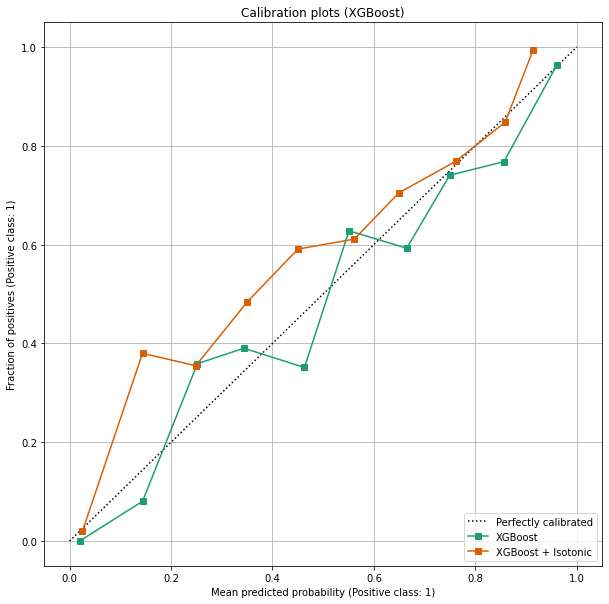

In [27]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (XGBoost)")

In [61]:
# Make predictions on the test set
y_pred = model_sigmoid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.8619091751621872,
  'recall': 0.8908045977011494,
  'f1-score': 0.8761186999528968,
  'support': 1044},
 '1': {'precision': 0.6951871657754011,
  'recall': 0.6356968215158925,
  'f1-score': 0.6641123882503193,
  'support': 409},
 'accuracy': 0.8189951823812801,
 'macro avg': {'precision': 0.7785481704687942,
  'recall': 0.7632507096085209,
  'f1-score': 0.7701155441016081,
  'support': 1453},
 'weighted avg': {'precision': 0.8149791670140829,
  'recall': 0.8189951823812801,
  'f1-score': 0.8164417684412972,
  'support': 1453}}

## Prediction for new sample

In [18]:
with open('../models/xgboost_categorical_not_calibrated.pickle','wb') as f:
    pickle.dump(model, f)

In [19]:
with open('../models/xgboost_categorical_not_calibrated.pickle', 'rb') as f:
  model_loaded = pickle.load(f)

In [20]:
def preprocess_input_features(features: dict) -> pd.DataFrame:
    new_sample = features
    new_sample = pd.DataFrame([new_sample])
    new_sample.course = new_sample.course.astype(cat_type)
    return new_sample

In [21]:
my_sample = {
 "escore_bruto_p1_etapa1": 6.034,
 "escore_bruto_p2_etapa1": 64.65,
 #"nota_redacao_etapa1": 9.733,
 "escore_bruto_p1_etapa2": 3.845,
 "escore_bruto_p2_etapa2": 63.826,
 #"nota_redacao_etapa2": 9.933,
 "escore_bruto_p1_etapa3": 7.14,
 "escore_bruto_p2_etapa3": 76.636,
 #"nota_redacao_etapa3": 9.931,
 "pseudo_argumento_final": 70.36833333333334,
 "min_flag": True,
 "median_flag": True,
 #"cotista": 0,
 "cotas_negros_flag": 0,
 #"publicas_flag": 0,
 "publicas1_flag": 0,
 "publicas2_flag": 0,
 "publicas3_flag": 0,
 "publicas4_flag": 0,
 "publicas5_flag": 0,
 "publicas6_flag": 0,
 "publicas7_flag": 0,
 "publicas8_flag": 0,
 "course": "MEDICINA (BACHARELADO)"
 }

In [22]:
my_sample = preprocess_input_features(my_sample)

In [23]:
X_train.loc[495].head(1).to_dict('records')

[{'escore_bruto_p1_etapa1': 7.758,
  'escore_bruto_p2_etapa1': 39.364,
  'escore_bruto_p1_etapa2': 6.152,
  'escore_bruto_p2_etapa2': 36.255,
  'escore_bruto_p1_etapa3': 6.426,
  'escore_bruto_p2_etapa3': 33.32,
  'pseudo_argumento_final': 35.30566666666667,
  'min_flag': True,
  'median_flag': False,
  'cotas_negros_flag': 0,
  'publicas1_flag': 0,
  'publicas2_flag': 0,
  'publicas3_flag': 0,
  'publicas4_flag': 0,
  'publicas5_flag': 1,
  'publicas6_flag': 0,
  'publicas7_flag': 1,
  'publicas8_flag': 0,
  'course': 'CIÊNCIA DA COMPUTAÇÃO (BACHARELADO)'}]

In [24]:
X_test.loc[3926].to_dict()

{'escore_bruto_p1_etapa1': 0.287,
 'escore_bruto_p2_etapa1': 28.157,
 'escore_bruto_p1_etapa2': 2.307,
 'escore_bruto_p2_etapa2': 42.262,
 'escore_bruto_p1_etapa3': 0.714,
 'escore_bruto_p2_etapa3': 34.747,
 'pseudo_argumento_final': 36.153666666666666,
 'min_flag': True,
 'median_flag': False,
 'cotas_negros_flag': 0,
 'publicas1_flag': 0,
 'publicas2_flag': 0,
 'publicas3_flag': 0,
 'publicas4_flag': 0,
 'publicas5_flag': 0,
 'publicas6_flag': 0,
 'publicas7_flag': 1,
 'publicas8_flag': 0,
 'course': 'MEDICINA (BACHARELADO)'}

In [25]:
my_sample2 = X_test.loc[[3926, 3936]]
#my_sample2['dist_min'] = my_sample2['dist_min'].astype("category")
#my_sample2['dist_median'] = my_sample2['dist_median'].astype("category")
my_sample2

,escore_bruto_p1_etapa1,escore_bruto_p2_etapa1,escore_bruto_p1_etapa2,escore_bruto_p2_etapa2,escore_bruto_p1_etapa3,escore_bruto_p2_etapa3,pseudo_argumento_final,min_flag,median_flag,cotas_negros_flag,publicas1_flag,publicas2_flag,publicas3_flag,publicas4_flag,publicas5_flag,publicas6_flag,publicas7_flag,publicas8_flag,course
3926,0.287,28.157,2.307,42.262,0.714,34.747,36.153667,True,False,0,0,0,0,0,0,0,1,0,MEDICINA (BACHARELADO)
3936,6.034,64.650,3.845,63.826,7.140,76.636,70.368333,True,True,0,0,0,0,0,0,0,0,0,MEDICINA (BACHARELADO)


In [ ]:
y_test

In [86]:
print(model.predict_proba(my_sample))
print(model.predict_proba(my_sample2))
#print(model_sigmoid.predict_proba(my_sample))
#print(model_sigmoid.predict_proba(X_test.head(13)))

[[0.22341824 0.77658176]]
[[0.99154323 0.00845676]
 [0.22341824 0.77658176]]
